<div>
    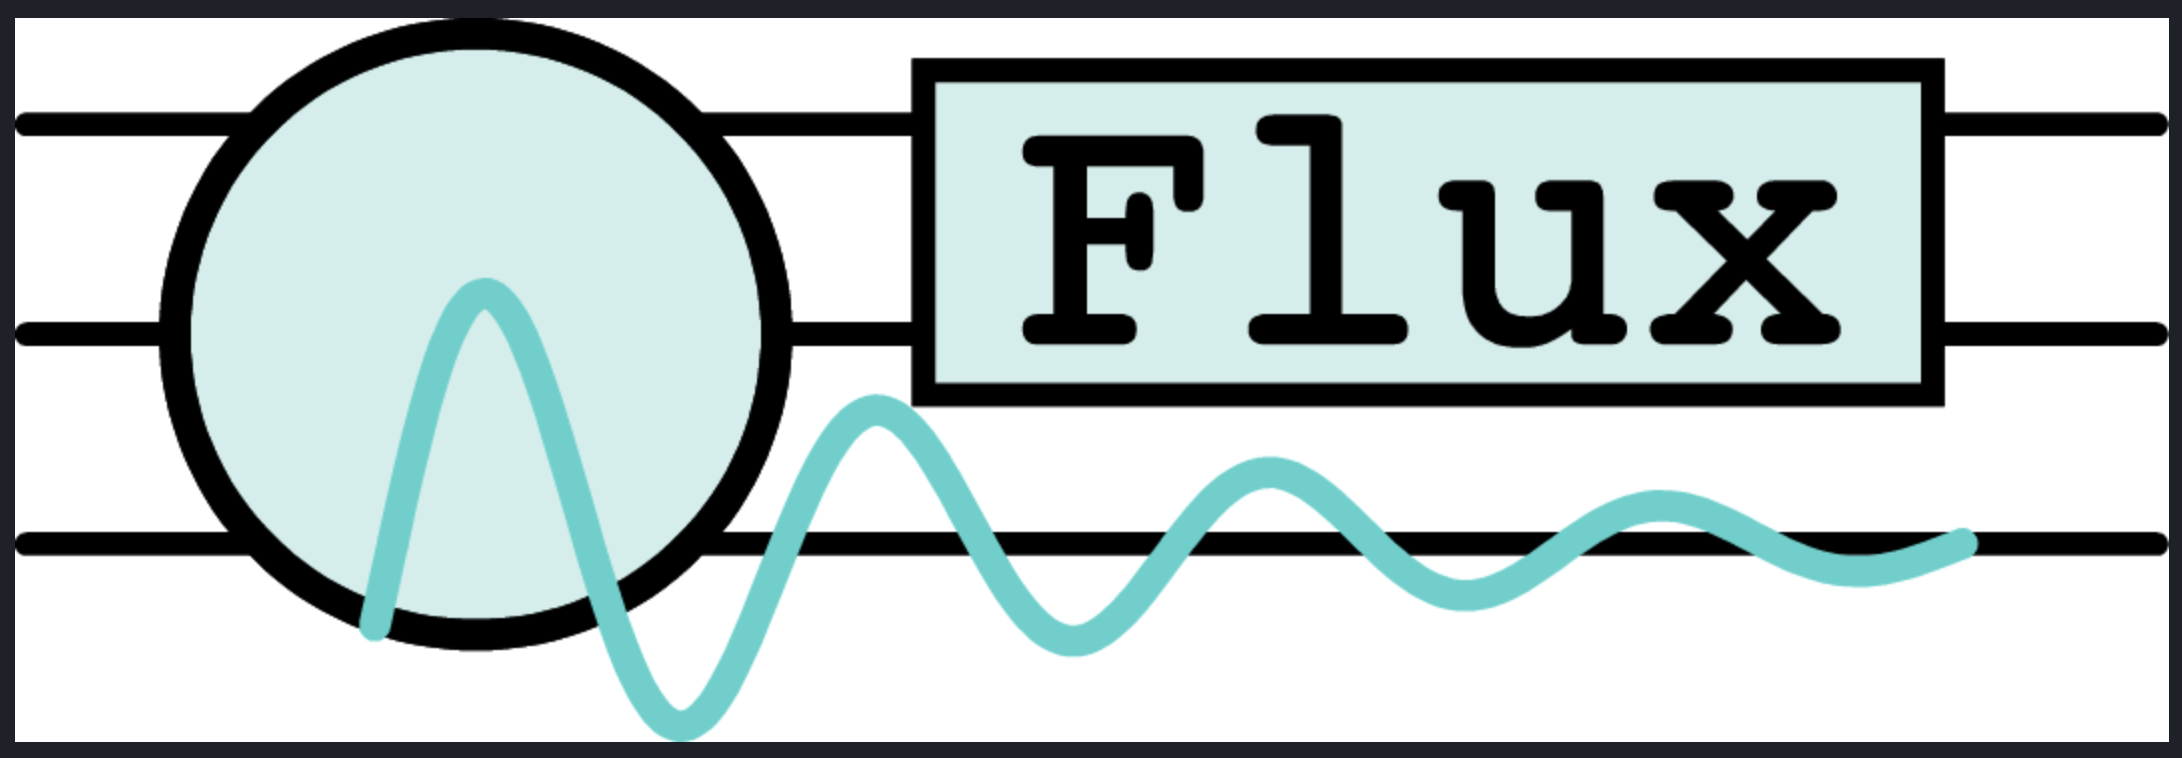
</div>

# Installation: Run the following cell to install QFlux in Colab

In [ ]:
!pip install qflux

# **QFlux Tutorial**

<h2> This notebook implements codes referenced in the Supporting Information for: </h2>

<h2> 
<b> QFlux: Quantum Circuit Implementations for Molecular Dynamics </b>
</h2>

<h2> <b> Part IV - Dilation method for Open Systems</b> </h2>

<h3> 
    <b> Authors: </b> <br><br>
Xiaohan Dan, Saurabh Shivpuje, Yuchen Wang, Brandon C. Allen, Delmar G. A. Cabral, Pouya Khazaei, Alexander V. Soudackov, Zixuan Hu, Ningyi Lyu, Eitan Geva, Sabre Kais, and Victor S. Batista</h3>

**Note:** Each section builds on the previous ones. **Execute the cells sequentially**, as later sections rely on functions and data defined earlier.

# Table of Contents

* Section 1

  - <a href="#ScriptSpt1pt1">Script S.1.1: Obtaining Kraus Operators From The Propagator</a>

* Section 2

  - <a href="#ScriptSpt2pt1">Script S.2.1: Dilation</a>

* Section 3

  - <a href="#ScriptSpt3pt1">Script S.3.1: Calculating The Propagator Of The Lindblad Equation</a>

  - <a href="#ScriptSpt3pt2">Script S.3.2: Solving The Lindblad Equation Via Matrix Exponential</a>

  - <a href="#ScriptSpt3pt3">Script S.3.3: QuTiP For Exact Solutions</a>

* Section 4

  - <a href="#ScriptSpt4pt1">Script S.4.1: Set Up The Spin-1/2 System</a>

  - <a href="#ScriptSpt4pt2">Script S.4.2: Propagate The Spin-1/2 System</a>

  - <a href="#ScriptSpt4pt3">Script S.4.3: Plot The Results: Spin 1/2 System</a>

  - <a href="#ScriptSpt4pt4">Script S.4.4: Simulating The Spin-1/2 System With QFlux</a>

  - <a href="#ScriptSpt4pt5">Script S.4.5: Quantum Simulation Of Amplitude Damping With QFlux</a>

  - <a href="#ScriptSpt4pt6">Script S.4.6: Plot The Population Dynamics</a>

  - <a href="#ScriptSpt4pt7">Script S.4.7: Amplitude Damping Channel: Propagator</a>

  - <a href="#ScriptSpt4pt8">Script S.4.8: Amplitude Damping Channel: Quantum Simulation</a>

* Section 5

  - <a href="#ScriptSpt5pt1">Script S.5.1: Spin Chain Parameter And Initial State</a>

  - <a href="#ScriptSpt5pt2">Script S.5.2: Spin Chain Hamiltonian</a>

  - <a href="#ScriptSpt5pt3">Script S.5.3: Spin Chain Collapse Operators</a>

  - <a href="#ScriptSpt5pt4">Script S.5.4: Spin Chain Dynamics</a>

  - <a href="#ScriptSpt5pt5">Script S.5.5: Plot The Results: Spin Chain</a>

  - <a href="#ScriptSpt5pt6">Script S.5.6: Simulating Spin Chain Dynamics With QFlux</a>

  - <a href="#ScriptSpt5pt7">Script S.5.7: Quantum Simulation Of Spin Chain With QFlux</a>

  - <a href="#ScriptSpt5pt8">Script S.5.8: Plot The Quantum Result Of Spin Chain</a>

  - <a href="#ScriptSpt5pt9">Script S.5.9: Quantum Simulation Of Spin Chain</a>

* Section 6

  - <a href="#ScriptSpt6pt1">Script S.6.1: Double-Well Potential</a>

  - <a href="#ScriptSpt6pt2">Script S.6.2: Eigenstates In The Double-Well Potential</a>

  - <a href="#ScriptSpt6pt3">Script S.6.3: Express Operators In Term Of Eigenstate Basis</a>

  - <a href="#ScriptSpt6pt4">Script S.6.4: Simulate The Dynamics Of The Double-Well</a>

  - <a href="#ScriptSpt6pt5">Script S.6.5: Simulating Double-Well Dynamics With QFlux</a>

  - <a href="#ScriptSpt6pt6">Script S.6.6: Quantum Simulation Of Double-Well With QFlux</a>

  - <a href="#ScriptSpt6pt7">Script S.6.7: The Double-Well Propagator</a>

  - <a href="#ScriptSpt6pt8">Script S.6.8: Obtaining Kraus Operators From The Propagator</a>

  - <a href="#ScriptSpt6pt9">Script S.6.9: Initial State And Observable</a>

  - <a href="#ScriptSpt6pt10">Script S.6.10: Quantum Simulation Of Double-Well</a>

# Section 1

## Script S.1.1: Obtaining Kraus Operators From The Propagator <a name="ScriptSpt1pt1"></a>

In [1]:
import numpy as np
import scipy.linalg as LA

def gen_Kraus_list(Gmat,N,tol=1E-5):
    """
    Generate the Kraus operators from the propagator with a given tolerance
    Input:
    - Gmat: matrix of the propagator (numpy array of shape (N^2, N^2)).
    - N: The system Hilbert space dimension
    - tol: tolerance for the Kraus operator representation.
    Returns:
    - Kraus: List of Kraus operators
    """
    # defining the Choi matrix from the matrix of the propagator
    C_mat = np.zeros(Gmat.shape,dtype=np.complex128)
    for i in range(N):
        for j in range(N):
            C_matij = np.zeros(Gmat.shape,dtype=np.complex128)
            for k in range(N):
                for l in range(N):
                    C_matij[i*N+k,l*N+j] = Gmat[j*N+k,l*N+i]
            C_mat += C_matij

    Kraus = []
    val,arr = LA.eigh(C_mat)
    for i in range(len(val)):
        if (val[i]>tol):
            Mi = np.sqrt(val[i])*arr[:,i].reshape(N,N)
            Kraus.append(Mi.conj().T)
    return Kraus



# Section 2

## Script S.2.1: Dilation <a name="ScriptSpt2pt1"></a>

In [2]:
def dilate(array,Isscale=True):

    if(Isscale):
        # Normalization factor, 1.1 times martix's norm to ensure contraction
        norm = LA.norm(array,2)*1.1
        array_new = array/norm
    else:
        array_new = array

    ident = np.eye(array.shape[0])

    # Calculate the conjugate transpose of the G propagator
    fcon = (array_new.conjugate()).T

    # Calculate the defect matrix for dilation
    fdef = LA.sqrtm(ident - np.dot(fcon, array_new))

    # Calculate the defect matrix for the conjugate of the G propagator
    fcondef = LA.sqrtm(ident - np.dot(array_new, fcon))

    # Dilate the G propagator to create a unitary operator
    array_dilated = np.block([[array_new, fcondef], [fdef, -fcon]])
    if(Isscale):
        return array_dilated, norm
    else:
        return array_dilated


# Section 3

## Script S.3.1: Calculating The Propagator Of The Lindblad Equation <a name="ScriptSpt3pt1"></a>

In [3]:
def Gt_matrix_expo(H, L, time_arr, Is_show_step = False):
    """
    Getting the propagator of the Lindblad equation by matrix exponential
    Parameters:
    - H: Hamiltonian of the system (numpy array of shape (N, N)).
    - time_arr: Time array for dynamic simulation (array).
    - L: List of Collapse operators, with each operator is a numpy array of shape (N, N).
    Returns:
    - G_prop: List of propagators.
    """
    Nsys = H.shape[0]
    ident_h = np.eye(Nsys, dtype=np.complex128)

    # Amatrix for time-derivation of the vectorized density matrix
    Amat = -1j * (np.kron(H, ident_h) - np.kron(ident_h, H.T))
    for i in range(len(L)):
        Amat += 0.5 * (2.0 * (np.kron(L[i], L[i].conj()))
                           - np.kron(ident_h, L[i].T @ L[i].conj())
                           - np.kron(L[i].T.conj() @ L[i], ident_h))

    G_prop = []
    for i in range(len(time_arr)):
        if(Is_show_step): print('step',i,'time',time_arr[i])
        Gt = LA.expm(Amat * time_arr[i])
        G_prop.append(Gt)
    return G_prop


## Script S.3.2: Solving The Lindblad Equation Via Matrix Exponential <a name="ScriptSpt3pt2"></a>

In [4]:
def propagate_matrix_exp(H, rho0, time_arr, L, observable, Is_store_state = False, Is_show_step = False, Is_Gt = False):
    """
    Solving the Lindblad equation by matrix exponential
    Parameters:
    - H: Hamiltonian of the system (numpy array of shape (N, N)).
    - rho0: Initial density matrix (numpy array of shape (N, N)).
    - time_arr: Time array for dynamic simulation (array).
    - L: List of Collapse operators, with each operator is a numpy array of shape (N, N).
    - observable: Observable for which the expectation value is computed (numpy array of shape (N, N)).
    - Is_store_state: Boolean variable that determines whether to output the density matrix list
    - show_step: Boolean variable that determines whether to print the current step during simulation
    Returns:
    - result: A class containing all the results
      result.expect: List of expectation values of the observable over time.
      result.G_prop: List of propagators.
      result.density_matrix: List of density matrices.
    """

    class Result:
        def __init__(self):
            self.expect = []
            if(Is_store_state):
                self.density_matrix = []
            if(Is_Gt):  self.Gprop = None
    result = Result()

    # Getting the propagator of the Lindblad equation
    G_prop = Gt_matrix_expo(H, L, time_arr, Is_show_step)
    if(Is_Gt):  result.Gprop = G_prop

    # initialized vectorized density matrix
    Nsys = H.shape[0]
    vec_rho0 = rho0.reshape(Nsys**2)

    for i in range(len(time_arr)):

        vec_rhot = G_prop[i] @ vec_rho0

        # get the density matrix by reshaping
        rhot = vec_rhot.reshape(Nsys, Nsys)

        if(Is_store_state):  result.density_matrix.append(rhot)
        result.expect.append(np.trace(rhot @ observable).real)

    return result


## Script S.3.3: QuTiP For Exact Solutions <a name="ScriptSpt3pt3"></a>

In [5]:
from qutip import mesolve, Qobj

def qutip_prop(H, rho0, time_arr, c_ops, observable):
    """
    First import the mesolve function, which is used to solve master equations, and the Qobj class, which is used to represent quantum objects, from the QuTiP library.
    - H: Hamiltonian of the system (Qobj).
    - rho0: Initial density matrix (Qobj).
    - time_arr: Time array for dynamic simulation (array).
    - c_ops: List of collapse operators (list of Qobj), can be empty for Liouville equation.
    - observable: Operator for which the expectation value is to be calculated (Qobj).
    Returns:
    - expec_vals: List of expectation values of the observable over time.
    """
    result = mesolve(H, rho0, time_arr, c_ops=c_ops, e_ops=observable)
    return result.expect


# Section 4

## Script S.4.1: Set Up The Spin-1/2 System <a name="ScriptSpt4pt1"></a>

In [6]:
from qflux.open_systems import params as pa

# The Spin-1/2 system Hamiltonian
H_1spin = 2 * np.pi * 0.1 * pa.X

# The jump operator and damping rate of Spin-1/2 system
gamma_1spin = 0.05
L_1spin = np.sqrt(gamma_1spin)*pa.X

# Initial density matrix
rho0_1spin = np.outer(pa.spin_up, pa.spin_up.conj())

# Time array for simulation
time_arr = np.linspace(0, (250 - 1) * 0.1, 250)


## Script S.4.2: Propagate The Spin-1/2 System <a name="ScriptSpt4pt2"></a>

In [7]:
# Matrix Exponential Propagation
result_matrix_exp = propagate_matrix_exp(H_1spin, rho0_1spin, time_arr, [L_1spin], pa.Z)

# QuTiP Propagation for Liouville equation (no collapse operator)
expec_vals_qutip_Liouv = qutip_prop(Qobj(H_1spin), Qobj(rho0_1spin), time_arr, [], Qobj(pa.Z))

# QuTiP Propagation for Lindblad equation
expec_vals_qutip_Lindblad = qutip_prop(Qobj(H_1spin), Qobj(rho0_1spin), time_arr, [Qobj(L_1spin)], Qobj(pa.Z))


## Script S.4.3: Plot The Results: Spin 1/2 System <a name="ScriptSpt4pt3"></a>

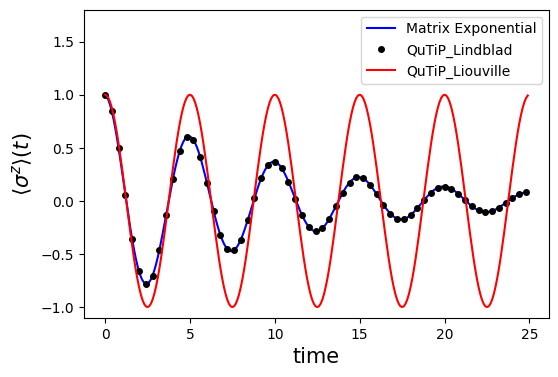

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(time_arr, result_matrix_exp.expect,'b-', label = "Matrix Exponential")
plt.plot(time_arr, expec_vals_qutip_Lindblad[0],'ko',markersize=4,markevery=4, label = "QuTiP_Lindblad")
plt.plot(time_arr, expec_vals_qutip_Liouv[0],'r-', label = "QuTiP_Liouville")
plt.xlabel('time',fontsize=15)
plt.ylabel(r'$\langle\sigma^z\rangle (t)$',fontsize=15)
plt.ylim(-1.1,1.8)
plt.legend(loc = 'upper right')
plt.show()


## Script S.4.4: Simulating The Spin-1/2 System With QFlux <a name="ScriptSpt4pt4"></a>

In [9]:
from qflux.open_systems import params as pa
from qflux.open_systems.numerical_methods import DynamicsOS
from qflux.open_systems.quantum_simulation import QubitDynamicsOS
import numpy as np

# Classical Simulation
# set the Hamiltonian and initial state
# The Spin-1/2 system Hamiltonian
Hsys = 2 * np.pi * 0.1 * pa.X

# The collapse operator and damping rate of Spin-1/2 system
gamma = 0.05
c_ops = np.sqrt(gamma)*pa.X

# Initial density matrix
rho0 = np.outer(pa.spin_up, pa.spin_up.conj())

# Time array for simulation
time_arr = np.linspace(0, (250 - 1) * 0.1, 250)

# instantiation
spin1_puresys = DynamicsOS(Nsys=2, Hsys=Hsys, rho0=rho0)
spin1_dissipative = DynamicsOS(Nsys=2, Hsys=Hsys, rho0=rho0, c_ops = [c_ops])

# propagation
# QuTiP Propagation for the pure system Liouville equation (for comparison)
expec_vals_qutip_Liouv = spin1_puresys.propagate_qt(time_arr=time_arr, observable=pa.Z)

# matrix exponential propagation
result_matrix_exp = spin1_dissipative.propagate_matrix_exp(time_arr=time_arr, observable=pa.Z)

# QuTiP Propagation for the Lindblad equation
expec_vals_qutip_Lindblad = spin1_dissipative.propagate_qt(time_arr=time_arr, observable=pa.Z)


## Script S.4.5: Quantum Simulation Of Amplitude Damping With QFlux <a name="ScriptSpt4pt5"></a>

In [10]:
import numpy as np

# Quantum Simulation: Amplitude damping channel
# System Hamiltonian
Hsys = 0.0 * pa.I

# The collapse operator and damping rate
gamma = 1.52e9*1E-12 # the spontaneous emission rate, ps^-1
c_ops = np.sqrt(gamma)*pa.sigmap

# Initial density matrix
rho0_sdam = np.array([[1/4,1/4],[1/4,3/4]],dtype=np.complex128)

time_sdam = np.arange(0, 1000, 1) #time array, from t=0 to t=1000 ps

# instantiation
spin1_sdam = QubitDynamicsOS(rep='Density', Nsys=2, Hsys=Hsys, rho0=rho0_sdam, c_ops = [c_ops])
# set qubit state to measurement
spin1_sdam.set_count_str(['000','011'])
# set the dilation method, which can be 'Sz-Nagy' or 'SVD' or 'SVD-Walsh'
spin1_sdam.set_dilation_method('SVD')

# quantum simulation
Pop_qc = spin1_sdam.qc_simulation_vecdens(time_sdam)

# compare to classical
res_sdam_classical = spin1_sdam.propagate_matrix_exp(time_sdam, observable=pa.Z, Is_store_state = True)

Pop_Mexp = np.zeros_like(Pop_qc['data'])
for i in range(len(time_sdam)):
    Pop_Mexp[i,0] = res_sdam_classical.density_matrix[i][0,0].real
    Pop_Mexp[i,1] = res_sdam_classical.density_matrix[i][1,1].real


Quantum simulation step 0
Quantum simulation step 100
Quantum simulation step 200
Quantum simulation step 300
Quantum simulation step 400
Quantum simulation step 500
Quantum simulation step 600
Quantum simulation step 700
Quantum simulation step 800
Quantum simulation step 900


## Script S.4.6: Plot The Population Dynamics <a name="ScriptSpt4pt6"></a>

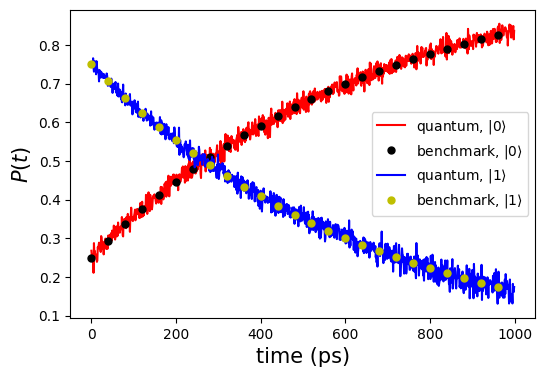

In [13]:
plt.figure(figsize=(6,4))
plt.plot(time_sdam,Pop_qc['data'][:,0],'r-',label=r"quantum, $|0\rangle$")
plt.plot(time_sdam,Pop_Mexp[:,0],'ko',markersize=5,markevery=40,label=r"benchmark, $|0\rangle$")
plt.plot(time_sdam,Pop_qc['data'][:,1],'b-',label=r"quantum, $|1\rangle$")
plt.plot(time_sdam,Pop_Mexp[:,1],'yo',markersize=5,markevery=40,label=r"benchmark, $|1\rangle$")
plt.xlabel('time (ps)',fontsize=15)
plt.ylabel('$P(t)$',fontsize=15)
plt.legend(loc = 'center right')
plt.show()



## Script S.4.7: Amplitude Damping Channel: Propagator <a name="ScriptSpt4pt7"></a>

In [15]:
gamma = 1.52e9*1E-12 # the spontaneous emission rate, ps^-1
time_sdam = np.arange(0, 1000, 1) # time array, from t=0 to t=1000 ps
Nsys_1spin = 2

# defining the initial density matrix rho
rho0_sdam = np.array([[1/4,1/4],[1/4,3/4]],dtype=np.complex128)
vec0_sdam = rho0_sdam.reshape(Nsys_1spin**2)
norm0_sdam = LA.norm(vec0_sdam,2)
vec0_sdam /= norm0_sdam

Pop_Mexp = np.zeros((len(time_sdam),2),dtype=np.float64) #population array

Gprop_sdam = Gt_matrix_expo(0.0*pa.X, [np.sqrt(gamma)*pa.sigmap], time_sdam)

for i in range(len(time_sdam)):

    Gt = Gprop_sdam[i]
    rhot_sdam = (Gt@vec0_sdam).reshape(Nsys_1spin,Nsys_1spin)*norm0_sdam
    Pop_Mexp[i,0] = rhot_sdam[0,0].real
    Pop_Mexp[i,1] = rhot_sdam[1,1].real


## Script S.4.8: Amplitude Damping Channel: Quantum Simulation <a name="ScriptSpt4pt8"></a>

In [17]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator

# initial state in the dilated space
rho0_sdam_dil = np.concatenate((vec0_sdam,np.zeros(Nsys_1spin**2)))

aersim = AerSimulator()
shots = 2000
Pop_qc = np.zeros((len(time_sdam),2),dtype=np.float64)

for i in range(len(time_sdam)):
    if(i%100==0):print('istep',i)
    qr = QuantumRegister(2+1)  # Create a quantum register
    cr = ClassicalRegister(2+1)  # Create a classical register to store measurement results
    qc = QuantumCircuit(qr, cr)  # Combine the quantum and classical registers to create the quantum circuit

    # Initialize the quantum circuit with the initial state
    qc.initialize(rho0_sdam_dil, qr)
    # Dilated propagator
    U_G, norm = dilate(Gprop_sdam[i])

    # Create a custom unitary operator with the dilated propagator
    U_G_op = Operator(U_G)
    # Apply the unitary operator to the quantum circuit's qubits and measure
    qc.unitary(U_G_op, qr)
    qc.measure(qr, cr)

    counts1 = aersim.run(qc,shots=shots).result().get_counts()
    if '011' and '000' in counts1:
        Pop_qc[i,0] = np.sqrt(counts1['000']/shots)*norm*norm0_sdam
        Pop_qc[i,1] = np.sqrt(counts1['011']/shots)*norm*norm0_sdam
    else:
        print(i,'shots=',shots,"no counts for up state")


istep 0
istep 100
istep 200
istep 300
istep 400
istep 500
istep 600
istep 700
istep 800
istep 900


# Section 5

## Script S.5.1: Spin Chain Parameter And Initial State <a name="ScriptSpt5pt1"></a>

In [18]:
# the system Hamiltonian parameter
nsite = 3 #this states how many spins in the simulation
Nsys_sc = 2**nsite #this is the dimension of the Hilbert space
Omegai_list = [0.65, 1.0, 1.0]
Jix_list = [0.75, 1.0]
Jiy_list = [0.75, 1.0]
Jiz_list = [0.0, 0.0]

# set up the initial state at [up,down,down...]
init_state = pa.spin_up
for i in range(nsite-1):
    init_state = np.kron(init_state,pa.spin_down)

# set up the initial density matrix according to initial state
rho0_sc = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex128)
rho0_sc += np.outer(init_state,init_state.conj())

# time array for simulation
nsteps = 250
time_arr = np.linspace(0, (nsteps - 1) * 0.1, nsteps)


## Script S.5.2: Spin Chain Hamiltonian <a name="ScriptSpt5pt2"></a>

In [19]:
# the diagonal part of the Hamiltonian
H_diag = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex128)
for n in range(nsite):
    tmp = 1.0
    for i in range(nsite):
        if(i==n):
            tmp = np.kron(tmp,pa.Z)
        else:
            tmp = np.kron(tmp,pa.I)
    H_diag += Omegai_list[n]*tmp

# the non-diagnoal (coupling) part of the Hamiltonian
H_coup = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex128)
XX = np.kron(pa.X,pa.X)
YY = np.kron(pa.Y,pa.Y)
ZZ = np.kron(pa.Z,pa.Z)
for n in range(nsite-1):
    coup_tmp = Jix_list[n]*XX+Jiy_list[n]*YY+Jiz_list[n]*ZZ
    tmp = 1.0
    for i in range(nsite-1):
        if(n==i):
            tmp = np.kron(tmp,coup_tmp)
        else:
            tmp = np.kron(tmp,pa.I)
    H_coup += tmp
Hsys_sc = H_diag - 0.5 * H_coup
Hsys_sc_qobj = Qobj(Hsys_sc)


## Script S.5.3: Spin Chain Collapse Operators <a name="ScriptSpt5pt3"></a>

In [20]:
# The lindblad damping rate
Gamma1 = [0.016]*nsite
Gamma2 = [0.0523]*nsite

# The Collapse operators
L_sc = []
L_sc_qobj = [] #this stores Qobj type for QuTiP methods

sigma2 = pa.sigmap@pa.sigmam

for isite in range(nsite):
    # Lindbladian for type 1
    res = 1.0
    for j in range(nsite):
        if(j==isite):
            res = np.kron(res,pa.sigmam)*np.sqrt(Gamma1[isite])
        else:
            res = np.kron(res,pa.I)
    L_sc.append(res)
    L_sc_qobj.append(Qobj(res))

    # Lindbladian for type 2
    res = 1.0
    for j in range(nsite):
        if(j==isite):
            res = np.kron(res,sigma2)*np.sqrt(Gamma2[isite])
        else:
            res = np.kron(res,pa.I)
    L_sc.append(res)
    L_sc_qobj.append(Qobj(res))


## Script S.5.4: Spin Chain Dynamics <a name="ScriptSpt5pt4"></a>

In [21]:
# Matrix Exponential Propagation
result_matrix_exp = propagate_matrix_exp(Hsys_sc, rho0_sc, time_arr, L_sc, rho0_sc)

rho0_sc_qobj = Qobj(rho0_sc)
# QuTiP Propagation for Liouville equation (no collapse operator)
result_qutip_Liouv = qutip_prop(Hsys_sc_qobj, rho0_sc_qobj, time_arr, [], rho0_sc_qobj)

# QuTiP Propagation for Lindblad equation
result_qutip_Lindblad = qutip_prop(Hsys_sc_qobj, rho0_sc_qobj, time_arr, L_sc_qobj, rho0_sc_qobj)

As_matrix_exp = np.sqrt(result_matrix_exp.expect[:])
As_qutip = np.sqrt(result_qutip_Lindblad[0][:])
As_qutip_liouv = np.sqrt(result_qutip_Liouv[0][:])


## Script S.5.5: Plot The Results: Spin Chain <a name="ScriptSpt5pt5"></a>

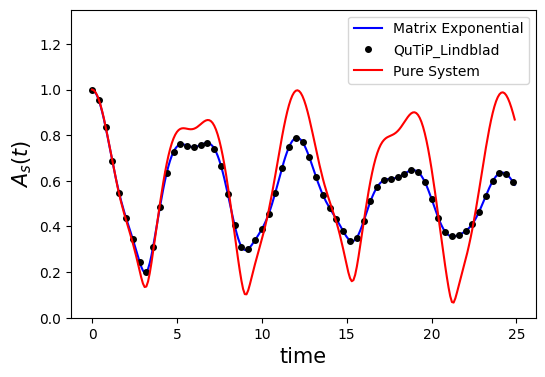

In [37]:
plt.figure(figsize=(6,4))
plt.plot(time_arr,As_matrix_exp,'b-', label="Matrix Exponential")
plt.plot(time_arr,As_qutip,'ko',markersize=4,markevery=4,label="QuTiP_Lindblad")
plt.plot(time_arr,As_qutip_liouv,'r-',label="Pure System")
plt.xlabel('time',fontsize=15)
plt.ylabel('$A_s(t)$',fontsize=15)
plt.ylim(0,1.35)
plt.legend(loc = 'upper right')
plt.show()


## Script S.5.6: Simulating Spin Chain Dynamics With QFlux <a name="ScriptSpt5pt6"></a>

In [29]:
from qflux.open_systems import DynamicsOS

# Classical Simulation
# instantiation
spin_chain_puresys =  DynamicsOS(Nsys=Nsys_sc, Hsys=Hsys_sc, rho0=rho0_sc)
spin_chain_opensys =  DynamicsOS(Nsys=Nsys_sc, Hsys=Hsys_sc, rho0=rho0_sc, c_ops = L_sc)

# propagation
# QuTiP Propagation for the pure system Liouville equation (for comparison)
result_qutip_Liouv = spin_chain_puresys.propagate_qt(time_arr=time_arr, observable=rho0_sc)

# matrix exponential propagation
result_matrix_exp = spin_chain_opensys.propagate_matrix_exp(time_arr=time_arr, observable=rho0_sc)

# QuTiP Propagation for the Lindblad equation
result_qutip_Lindblad = spin_chain_opensys.propagate_qt(time_arr=time_arr, observable=rho0_sc)

As_matrix_exp = np.sqrt(result_matrix_exp.expect[:])
As_qutip = np.sqrt(result_qutip_Lindblad[0][:])
As_qutip_liouv = np.sqrt(result_qutip_Liouv[0][:])


## Script S.5.7: Quantum Simulation Of Spin Chain With QFlux <a name="ScriptSpt5pt7"></a>

In [30]:
from qflux.open_systems import QubitDynamicsOS

# Quantum Simulation
qspin_chain = QubitDynamicsOS(rep='Density',Nsys=Nsys_sc, Hsys=Hsys_sc, rho0=rho0_sc, c_ops = L_sc)
qspin_chain.set_count_str(['0011011'])

res_qc_1k = qspin_chain.qc_simulation_vecdens(time_arr,shots=1000)
res_qc_1w = qspin_chain.qc_simulation_vecdens(time_arr,shots=10000)

As_qc_1k = np.sqrt(res_qc_1k['data'])
As_qc_1w = np.sqrt(res_qc_1w['data'])


Quantum simulation step 0
At time 32 with shots = 1000 no counts for 0011011
At time 33 with shots = 1000 no counts for 0011011
Quantum simulation step 100
Quantum simulation step 200
Quantum simulation step 0
Quantum simulation step 100
Quantum simulation step 200


## Script S.5.8: Plot The Quantum Result Of Spin Chain <a name="ScriptSpt5pt8"></a>

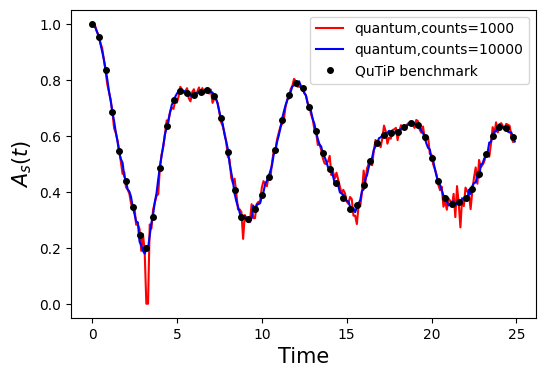

In [38]:
plt.figure(figsize=(6,4))
plt.plot(time_arr,As_qc_1k[:],'r-',label=f"quantum,counts={1000}")
plt.plot(time_arr,As_qc_1w[:],'b-',label=f"quantum,counts={10000}")
plt.plot(time_arr,As_qutip,'ko',markersize=4,markevery=4,label="QuTiP benchmark")
plt.xlabel('Time',fontsize=15)
plt.ylabel('$A_s(t)$',fontsize=15)
plt.legend(loc = 'upper right')
plt.show()


## Script S.5.9: Quantum Simulation Of Spin Chain <a name="ScriptSpt5pt9"></a>

In [40]:
# initial state of the spin chain in the dilated space
# rho0_sc=|up,down,...><up,down,...|, has defined in the Digital computer simulation part
rho0_sc_dil = np.concatenate((rho0_sc.reshape(Nsys_sc**2),np.zeros(Nsys_sc**2)))

# The propagator of the spin chain Lindblad equation
Gprop_sc = Gt_matrix_expo(Hsys_sc, L_sc, time_arr)

aersim=AerSimulator()
shots_arr = [1000,10000]
As_qc_1k = np.zeros((nsteps),dtype=np.float64)
As_qc_1w = np.zeros((nsteps),dtype=np.float64)
As_qc = [As_qc_1k,As_qc_1w]
nsteps = len(time_arr)

for i in range(nsteps):
    if(i%10==0):print('istep',i)
    qr = QuantumRegister(nsite*2+1)  # Create a quantum register
    cr = ClassicalRegister(nsite*2+1)  # Create a classical register to store measurement results
    qc = QuantumCircuit(qr, cr)  # Combine the quantum and classical registers to create the quantum circuit

    # Initialize the quantum circuit with the initial state
    qc.initialize(rho0_sc_dil, qr)
    # Dilated propagator
    U_G, norm = dilate(Gprop_sc[i])

    # Create a custom unitary operator with the dilated propagator
    U_G_op = Operator(U_G)

    # Apply the unitary operator to the quantum circuit's qubits
    qc.unitary(U_G_op, qr)

    qc.measure(qr, cr)

    for ishot in range(len(shots_arr)):
        counts1 = aersim.run(qc,shots=shots_arr[ishot]).result().get_counts()
        if '0011011' in counts1:
            survi_amp = np.sqrt(counts1['0011011']/shots_arr[ishot])*norm
            As_qc[ishot][i] = np.sqrt(survi_amp)
        else:
            print(i,'shots=',shots_arr[ishot],"no counts")


istep 0
istep 10
istep 20
istep 30
30 shots= 1000 no counts
31 shots= 1000 no counts
istep 40
istep 50
istep 60
istep 70
istep 80
istep 90
istep 100
istep 110
istep 120
istep 130
istep 140
istep 150
istep 160
istep 170
istep 180
istep 190
istep 200
istep 210
istep 220
istep 230
istep 240


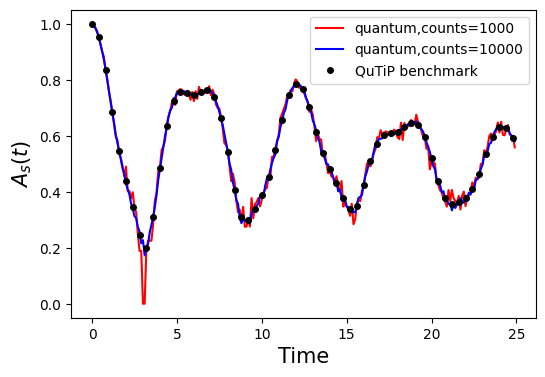

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(time_arr,As_qc_1k[:],'r-',label=f"quantum,counts={1000}")
plt.plot(time_arr,As_qc_1w[:],'b-',label=f"quantum,counts={10000}")
plt.plot(time_arr,As_qutip,'ko',markersize=4,markevery=4,label="QuTiP benchmark")
plt.xlabel('Time',fontsize=15)
plt.ylabel('$A_s(t)$',fontsize=15)
plt.legend(loc = 'upper right')
plt.show()


# Section 6

## Script S.6.1: Double-Well Potential <a name="ScriptSpt6pt1"></a>

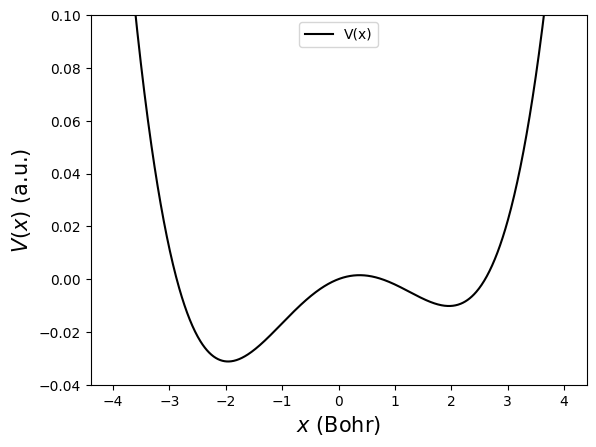

In [45]:
def pot_doublewell(x, f=0.0367493, a0=0.0, a1=0.429, a2=-1.126, a3=-0.143, a4=0.563):
    # A-T pair double-well potential in Hartrees (x is in Bohr)
    xi = x/1.9592
    return f*(a0 + a1*xi + a2*xi**2 + a3*xi**3 + a4*xi**4)

# The parameters
# Note that some unit conversion constants are defined in the pa object (an implementation of the Params class)
mass0 = 1836.15
beta = pa.au2joule/(pa.bolz*300) #1/(kT) in a.u. units
omega = 0.00436 #the frequency associate with the right well
kappa = 1/(10/pa.au2fs)
nth = 1/(np.exp(beta*omega)-1)

# set up the grid point
xmin = -4.0
xmax = 4.0
ndvr = 1024
xgrid = np.linspace(xmin,xmax,ndvr)

pot_arr = pot_doublewell(xgrid)

plt.plot(xgrid,pot_arr,'k', label = "V(x)")
plt.xlabel('$x$ (Bohr)',fontsize=15)
plt.ylabel('$V(x)$ (a.u.)',fontsize=15)
plt.ylim(-0.04,0.1)
plt.legend(loc = 'upper center')
plt.show()


## Script S.6.2: Eigenstates In The Double-Well Potential <a name="ScriptSpt6pt2"></a>

In [46]:
import scipy.fft as sfft

def get_eig_state(hamk,pot,xgrid,Nstate):
    """
    get the eigen state for potential in x-space
    input:kinetic energy hamiltonian, potential in x-space
    """
    Mata = hamk.copy()
    for i in range(ndvr):
        Mata[i,i]+=pot[i]

    val,arr = LA.eigh(Mata)
    dx = xgrid[1]-xgrid[0]
    return val[:Nstate],arr[:,:Nstate]/dx**0.5

kgrid = np.zeros(ndvr,dtype=np.float64)
# ak2: kinetic energy array in k-space
ak2   = np.zeros(ndvr,dtype=np.float64)

dx = xgrid[1]-xgrid[0]
dk = 2.0*np.pi/((ndvr)*dx)
coef_k = pa.hbar**2/(2.0*mass0)

for i in range(ndvr):
  if(i<ndvr//2):
    kgrid[i] = i*dk
  else:
    kgrid[i] = -(ndvr-i) * dk

  ak2[i] = coef_k*kgrid[i]**2

akx0 = sfft.ifft(ak2)
# hamk: kinetic hamiltonian Matrix in position x grid space
hamk = np.zeros((ndvr,ndvr),dtype=np.complex128)

for i in range(ndvr):
  for j in range(ndvr):
    if(i<j):
      hamk[i,j] = akx0[i-j].conj()
    else:
      hamk[i,j] = akx0[i-j]

Neig = 50
eneg_DW,psi_DW = get_eig_state(hamk,pot_arr,xgrid,Neig)


## Script S.6.3: Express Operators In Term Of Eigenstate Basis <a name="ScriptSpt6pt3"></a>

In [47]:
# the eigenstate in the k-space representation
# ( by Fourier transform of the original eigenstate in x-space)
psik_DW = np.zeros((ndvr,Neig),dtype=np.complex128)
pre_fac = dx/(2*np.pi)**0.5
for i in range(Neig):
    psik_DW[:,i] = sfft.fft(psi_DW[:,i])*pre_fac

# initial density matrix
ini_occu = np.zeros(Neig,dtype=np.complex128)
ini_occu[5] = 1.0
rho0 = np.outer(ini_occu,ini_occu.conj())

# The operator in the eigenstate
xmat_eig = np.zeros((Neig,Neig),dtype=np.complex128)
pmat_eig = np.zeros((Neig,Neig),dtype=np.complex128)
for i in range(Neig):
    for j in range(Neig):
        xmat_eig[i,j] = np.dot(np.multiply(psi_DW[:,i].conj(),xgrid),psi_DW[:,j])*dx
        pmat_eig[i,j] = np.dot(np.multiply(psik_DW[:,i].conj(),kgrid),psik_DW[:,j])*dk

# hamiltonian
H_dw = np.diag(eneg_DW)
# creation/annihilation operator
amat_eig = xmat_eig.copy()*np.sqrt(mass0*omega/2)+1j*pmat_eig.copy()/np.sqrt(mass0*omega*2)
adegmat_eig = xmat_eig.copy()*np.sqrt(mass0*omega/2)-1j*pmat_eig.copy()/np.sqrt(mass0*omega*2)

# define the population on the left/right well
x_barrier = 0.37321768
P_R = np.heaviside(xgrid-x_barrier,1)
P_L = 1 - np.heaviside(xgrid-x_barrier,1)

P_R_eig = np.zeros((Neig,Neig),dtype=np.complex128)
P_L_eig = np.zeros((Neig,Neig),dtype=np.complex128)
for i in range(Neig):
    for j in range(Neig):
        P_R_eig[i,j] = np.dot(np.multiply(psi_DW[:,i].conj(),P_R),psi_DW[:,j])*dx
        P_L_eig[i,j] = np.dot(np.multiply(psi_DW[:,i].conj(),P_L),psi_DW[:,j])*dx


## Script S.6.4: Simulate The Dynamics Of The Double-Well <a name="ScriptSpt6pt4"></a>

In [ ]:
# propagate using QuTiP
gamma1 = np.sqrt(kappa*(nth+1))
gamma2 = np.sqrt(kappa*(nth))
time_qtp = np.linspace(0,1000/pa.au2fs,20000)

# run the dynamics with different eigenstates truncation
result_qtp = {}
for N_eig_use in [20,30,40]:
    c_ops = [gamma1*Qobj(amat_eig[:N_eig_use,:N_eig_use]), gamma2*Qobj(adegmat_eig[:N_eig_use,:N_eig_use])]
    obs = [Qobj(P_R_eig[:N_eig_use,:N_eig_use]), Qobj(P_L_eig[:N_eig_use,:N_eig_use])]
    result_qtp[N_eig_use] = mesolve(Qobj(H_dw[:N_eig_use,:N_eig_use]),
                                    Qobj(rho0[:N_eig_use,:N_eig_use]),
                                    time_qtp, c_ops, obs,
                                    options={"progress_bar": "text"}).expect

# propagation using matrix exponential propagation
N_eig_use=30
c_ops = [gamma1*amat_eig[:N_eig_use,:N_eig_use], gamma2*adegmat_eig[:N_eig_use,:N_eig_use]]
observable = P_R_eig[:N_eig_use,:N_eig_use]

time_short = np.linspace(0,1000/pa.au2fs,30) #compare to QuTiP time scale
result_s = propagate_matrix_exp(H_dw[:N_eig_use,:N_eig_use], rho0[:N_eig_use,:N_eig_use],
                                time_short, c_ops, observable, Is_show_step=True)

time_long = np.linspace(0,20000/pa.au2fs,60) #long time propagation
result_dw_l = propagate_matrix_exp(H_dw[:N_eig_use,:N_eig_use], rho0[:N_eig_use,:N_eig_use],
                                   time_long, c_ops, observable,
                                   Is_store_state = True, Is_show_step=True, Is_Gt=True)


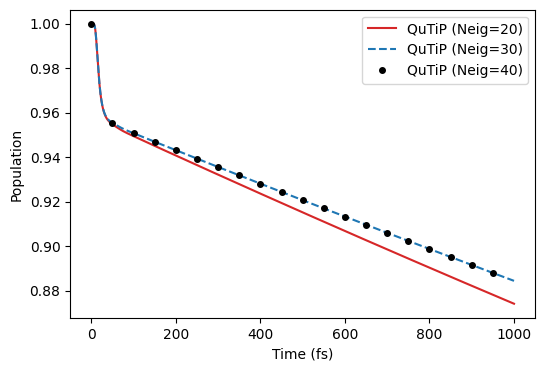

In [67]:
import matplotlib.pyplot as plt
from qflux.open_systems import params as pa

plt.figure(figsize=(6,4))
plt.plot(time_qtp*pa.au2fs, result_qtp[20][0], color='tab:red', label='QuTiP (Neig=20)')
plt.plot(time_qtp*pa.au2fs, result_qtp[30][0], '--', color='tab:blue', label='QuTiP (Neig=30)')
plt.plot(time_qtp*pa.au2fs, result_qtp[40][0], 'o', color='k', label='QuTiP (Neig=40)', markevery=1000, ms=4)
_ = plt.legend()
plt.xlabel('Time (fs)')
plt.ylabel('Population')
plt.show()

Text(0, 0.5, 'Population')

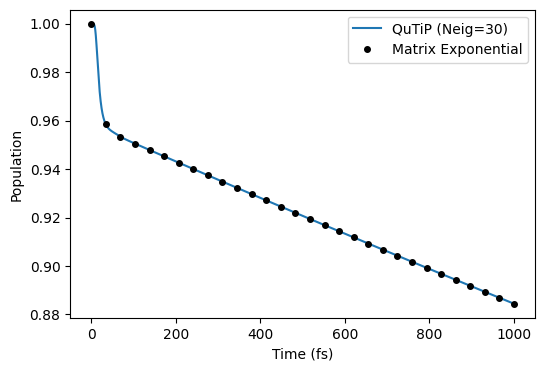

In [68]:
import matplotlib.pyplot as plt
from qflux.open_systems import params as pa

plt.figure(figsize=(6,4))
plt.plot(time_qtp*pa.au2fs, result_qtp[30][0], color='tab:blue', label='QuTiP (Neig=30)')
plt.plot(time_short*pa.au2fs, result_s.expect, 'o', color='k', label='Matrix Exponential', ms=4)
_ = plt.legend()
plt.xlabel('Time (fs)')
plt.ylabel('Population')

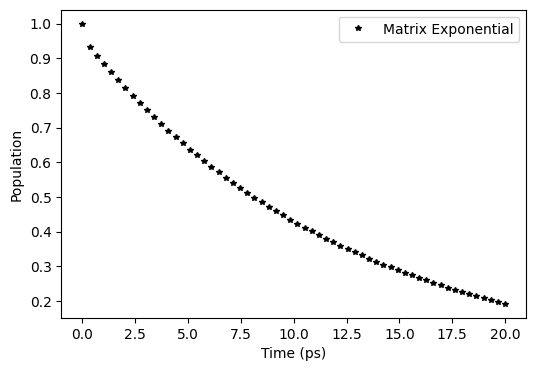

In [72]:
import matplotlib.pyplot as plt
from qflux.open_systems import params as pa

plt.figure(figsize=(6,4))
plt.plot(time_long*pa.au2fs/1000, result_dw_l.expect, '*', color='k', label='Matrix Exponential', ms=4)
_ = plt.legend()
plt.xlabel('Time (ps)')
plt.ylabel('Population')
plt.show()

## Script S.6.5: Simulating Double-Well Dynamics With QFlux <a name="ScriptSpt6pt5"></a>

In [74]:
# ==================classical simulation============================
# propagate using QuTiP
gamma1 = np.sqrt(kappa*(nth+1))
gamma2 = np.sqrt(kappa*(nth))

time_qtp = np.linspace(0,1000/pa.au2fs,20000)

# Double_Well with different eigenstates truncation
dw_eig = {}
result_qtp = {}
for N_eig_use in [20,30,40]:
    c_ops = [gamma1*amat_eig[:N_eig_use,:N_eig_use], gamma2*adegmat_eig[:N_eig_use,:N_eig_use]]
    dw_eig[N_eig_use] = DynamicsOS(Nsys = N_eig_use, Hsys = H_dw[:N_eig_use,:N_eig_use], \
                                      rho0 = rho0[:N_eig_use,:N_eig_use], c_ops = c_ops)

    obs = [P_R_eig[:N_eig_use,:N_eig_use], P_L_eig[:N_eig_use,:N_eig_use]]
    result_qtp[N_eig_use] = dw_eig[N_eig_use].propagate_qt(time_qtp, obs, \
                                                           options={"progress_bar": "text"})

# propagate using matrix exponential propagation
N_eig_use=30
c_ops = [gamma1*amat_eig[:N_eig_use,:N_eig_use], gamma2*adegmat_eig[:N_eig_use,:N_eig_use]]
observable = P_R_eig[:N_eig_use,:N_eig_use]

time_short = np.linspace(0,1000/pa.au2fs,30) #compare to QuTiP time scale
result_s = dw_eig[N_eig_use].propagate_matrix_exp(time_short, observable, Is_show_step=True)

time_long = np.linspace(0,20000/pa.au2fs,60) #long time propagation
result_dw_l = dw_eig[N_eig_use].propagate_matrix_exp(time_long, observable, \
                                Is_store_state = True, Is_show_step=True, Is_Gt=True)


  0%|          | 0/19999 [00:00<?, ?it/s]

  0%|          | 0/19999 [00:00<?, ?it/s]

  0%|          | 0/19999 [00:00<?, ?it/s]

step 0 time 0.0
step 1 time 1425.5646405431376
step 2 time 2851.129281086275
step 3 time 4276.693921629412
step 4 time 5702.25856217255
step 5 time 7127.823202715688
step 6 time 8553.387843258824
step 7 time 9978.952483801962
step 8 time 11404.5171243451
step 9 time 12830.081764888238
step 10 time 14255.646405431376
step 11 time 15681.211045974513
step 12 time 17106.77568651765
step 13 time 18532.34032706079
step 14 time 19957.904967603925
step 15 time 21383.469608147065
step 16 time 22809.0342486902
step 17 time 24234.598889233337
step 18 time 25660.163529776477
step 19 time 27085.728170319613
step 20 time 28511.292810862753
step 21 time 29936.85745140589
step 22 time 31362.422091949025
step 23 time 32787.986732492165
step 24 time 34213.5513730353
step 25 time 35639.11601357844
step 26 time 37064.68065412158
step 27 time 38490.24529466472
step 28 time 39915.80993520785
step 29 time 41341.37457575099
step 0 time 0.0
step 1 time 14014.02527991559
step 2 time 28028.05055983118
step 3 tim

## Script S.6.6: Quantum Simulation Of Double-Well With QFlux <a name="ScriptSpt6pt6"></a>

In [75]:
from qflux.open_systems.quantum_simulation import expand

# ===============Quantum Simulation ====================================
dim_dw = 32

# initial state of the double-well in the dilated space
ini_occu = np.zeros(dim_dw,dtype=np.complex128)
ini_occu[5] = 1.0
rho0 = np.outer(ini_occu,ini_occu.conj())

# hamiltonian
Hsys = H_dw[:dim_dw,:dim_dw]

# collapse operator and observable
c_ops = [gamma1*amat_eig[:dim_dw,:dim_dw], gamma2*adegmat_eig[:dim_dw,:dim_dw]]
observable = P_R_eig[:dim_dw,:dim_dw]

# extract the propagator from result of classical simulation,
# and expand to match the dimension of qubit space
# For saving calculation, only choose some time points
ilarge = 5
nsteps = int(len(time_long)/ilarge)
time_qdw = np.zeros(nsteps)
Gprop_dw = []

for i0 in range(nsteps):
    i = i0*ilarge
    org_dim = result_dw_l.density_matrix[i].shape[0]
    Gprop_dw.append(expand(result_dw_l.Gprop[i],org_dim,dim_dw))

    time_qdw[i0] = time_long[i]

# double well instance
dw_quantum = QubitDynamicsOS(rep='Kraus', Nsys=dim_dw, Hsys=Hsys, rho0=rho0, c_ops = c_ops)
dw_quantum.set_observable(observable)

# running the quantum simulation
P_dw_qc = dw_quantum.qc_simulation_kraus(time_qdw, shots=2000,  Gprop = Gprop_dw, tolk = 1E-2, tolo = 5E-3)


Generating the Kraus operators
At step 0 of 12
At step 1 of 12
At step 2 of 12
At step 3 of 12
At step 4 of 12
At step 5 of 12
At step 6 of 12
At step 7 of 12
At step 8 of 12
At step 9 of 12
At step 10 of 12
At step 11 of 12
Kraus operator generation complete
Number of initial states in the density matrix: 1
Probabilities: [np.float64(1.0)]
Starting quantum simulation
Simulation step 0 of 12
Number of Kraus operators: 1
Simulation step 1 of 12
Number of Kraus operators: 78
Simulation step 2 of 12
Number of Kraus operators: 76
Simulation step 3 of 12
Number of Kraus operators: 77
Simulation step 4 of 12
Number of Kraus operators: 76
Simulation step 5 of 12
Number of Kraus operators: 77
Simulation step 6 of 12
Number of Kraus operators: 77
Simulation step 7 of 12
Number of Kraus operators: 75
Simulation step 8 of 12
Number of Kraus operators: 75
Simulation step 9 of 12
Number of Kraus operators: 73
Simulation step 10 of 12
Number of Kraus operators: 76
Simulation step 11 of 12
Number of 

## Script S.6.7: The Double-Well Propagator <a name="ScriptSpt6pt7"></a>

In [76]:
def expand(Gmat_org,Norg,Nexpand):
    Gnew = np.zeros((Nexpand**2,Nexpand**2),dtype=np.complex128)
    for i in range(Norg):
        for j in range(Norg):
            for k in range(Norg):
                for l in range(Norg):
                    Gnew[i*Nexpand+j,k*Nexpand+l] = Gmat_org[i*Norg+j,k*Norg+l]
    return Gnew

dim_dw = 32
Nqb_dw = int(np.log2(dim_dw))

# extract the propagator from result of classical simulation
Gprop_dw = []
for i in range(len(result_dw_l.Gprop)):
    org_dim = result_dw_l.density_matrix[i].shape[0]
    Gprop_dw.append(expand(result_dw_l.Gprop[i],org_dim,dim_dw))


## Script S.6.8: Obtaining Kraus Operators From The Propagator <a name="ScriptSpt6pt8"></a>

In [78]:
# For saving calculation, only choose some time points
ilarge = 5
nsteps = int(len(Gprop_dw)/ilarge)

Kraus_all = {}
for i0 in range(nsteps):
    i = i0*ilarge
    print('istep: ',i0)

    # get the kraus operators from the propagator
    Kraus_all[i0] = gen_Kraus_list(Gprop_dw[i],dim_dw,tol=1E-2)


Computing quantum dynamics:   0%|          | 0/12 [00:00<?, ?it/s]

## Script S.6.9: Initial State And Observable <a name="ScriptSpt6pt9"></a>

In [79]:
from qflux.open_systems.trans_basis import ham_to_pauli
from qiskit.quantum_info import SparsePauliOp
import numpy as np

# initial state of the double-well in the dilated space
ini_occu = np.zeros(dim_dw,dtype=np.complex128)
ini_occu[5] = 1.0
stat0_dil = np.concatenate((ini_occu,np.zeros(dim_dw)))


# decompose the dilated space observable into summation of tensor product of pauli matrices
Obs_mat = np.zeros((2*dim_dw,2*dim_dw),dtype=np.complex128)
Obs_mat[:dim_dw,:dim_dw] = P_R_eig[:dim_dw,:dim_dw]
Obs_paulis_dic = ham_to_pauli(Obs_mat, Nqb_dw+1, tol=5E-3)

# Prepare the qiskit observable from the pauli strings of observable matrix
data = []
coef = []
for key in Obs_paulis_dic:
    data.append(key)
    coef.append(Obs_paulis_dic[key])
obs_q = SparsePauliOp(data,coef)


## Script S.6.10: Quantum Simulation Of Double-Well <a name="ScriptSpt6pt10"></a>

In [87]:
from qiskit_aer.primitives import Estimator

# Aer implementation of an Estimator
estimator = Estimator()

shots = 2000

# For saving calculation, only choose some time points
ilarge = 5
nsteps = int(len(Gprop_dw)/ilarge)

time_dw_qc = np.zeros((nsteps),dtype=np.float64)
P_dw_qc = np.zeros((nsteps),dtype=np.float64)

for i0 in range(nsteps):

    i = i0*ilarge

    time_dw_qc[i0] = time_long[i]
    matKraus_list = Kraus_all[i0]
    print('istep: ', i0, 'Length: ', len(matKraus_list))

    for ikraus in range(len(matKraus_list)):

        # Create the quantum circuit
        qr = QuantumRegister(Nqb_dw+1)
        cr = ClassicalRegister(Nqb_dw+1)
        qc = QuantumCircuit(qr, cr)

        # Initialize the quantum circuit with the initial state
        qc.initialize(stat0_dil, qr)

        # Create a custom unitary operator with the dilated Kraus propagator
        UM = dilate(matKraus_list[ikraus],Isscale=False)
        UM_op = Operator(UM)

        # Apply the unitary operator to the quantum circuit's qubits
        qc.unitary(UM_op, qr)

        result = estimator.run(qc, obs_q, shots = shots).result()
        P_dw_qc[i0] += result.values[0]


Simultion in progress:   0%|          | 0/12 [00:00<?, ?it/s]

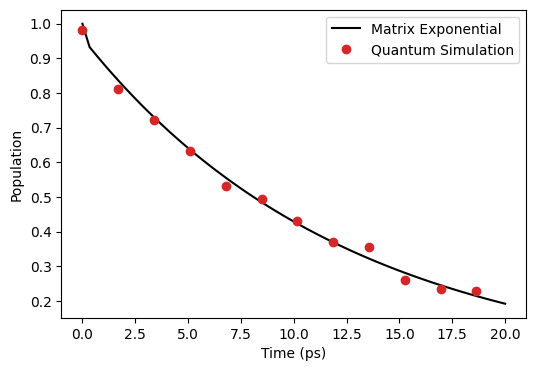

In [89]:
import matplotlib.pyplot as plt
from qflux.open_systems import params as pa

plt.figure(figsize=(6,4))
plt.plot(time_long*pa.au2fs/1000, result_dw_l.expect, color='k', label='Matrix Exponential', ms=4)
plt.plot(time_dw_qc*pa.au2fs/1000, P_dw_qc, 'o', color='tab:red', label="Quantum Simulation")
_ = plt.legend()
plt.xlabel('Time (ps)')
plt.ylabel('Population')
plt.show()